In [1]:
! pip install opendatasets

## downloading datasets from Kaggle- YOU MIGHT HAVE TO GIVE YOUR KAGGLE.JSON CREDENTIALS (USERNAME AND KEY) TO DOWNLOAD THE DATASETS

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition")
od.download("https://www.kaggle.com/datasets/madhusikha/foodcalories")

100%|█████████████████████████████████████████████████████████████████████████████| 1.98G/1.98G [01:02<00:00, 33.8MB/s]


100%|█████████████████████████████████████████████████████████████████████████████| 6.65k/6.65k [00:00<00:00, 2.27MB/s]

In [8]:
## IF YOU ARE RUNNING IN GOOGLE COLAB, UNCOMMENT THE FOLLOWING LINES IN THE CELL
# from google.colab import drive
# drive.mount('/content/drive')
# ! mkdir ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download kritikseth/fruit-and-vegetable-image-recognition
# ! kaggle datasets download vaishnavivenkatesan/food-and-their-calories
# ! kaggle datasets download madhusikha/foodcalories
# !unzip fruit-and-vegetable-image-recognition.zip
# !unzip food-and-their-calories.zip
# # google colab specific code
# train_path = '/content/train'
# test_path = '/content/test'
# validation_path = '/content/validation'

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt
from skimage.transform import resize       # for resizing image
import time
from sklearn.svm import SVC
import pickle
import random
import requests   # for webscraping
from bs4 import BeautifulSoup   # for webscraping
from skimage.feature import hog
from PIL import Image
from sklearn.metrics import accuracy_score
import json
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
# # IF YOU ARE RUNNING IN KAGGLE, UNCOMMENT THE FOLLOWING LINES IN THE CELL
# # kaggle directories
# train_path = '/kaggle/input/fruit-and-vegetable-image-recognition/train'
# test_path = '/kaggle/input/fruit-and-vegetable-image-recognition/test'
# validation_path = '/kaggle/input/fruit-and-vegetable-image-recognition/validation'

In [3]:
current_dir = os.getcwd()  # get the current working directory
data_dir = os.path.join(current_dir, 'fruit-and-vegetable-image-recognition')  # path to the images directory
train_path = os.path.join(data_dir, 'train')  # path to the train directory
test_path  = os.path.join(data_dir, 'test')  # path to the test directory
validation_path  = os.path.join(data_dir, 'validation')  # path to the validation directory

In [4]:
## SETTING THE FOLDER PATHS

## My OS has '\\' to separate one folder to other, your's might be different.. based on that, change the 'separator' in 1st line
## you change it based on your OS
## if your folder separation is '/' then replace '\\' by '/'

separator = '\\'
train_folder = glob(train_path+separator+'*')
test_folder = glob(test_path+separator+'*')


In [5]:
# printing different categories of the fruits and vegetables
labels = []
for j in train_folder:
#   print(j)
  labels.append(j.split(separator)[-1])

labels

['apple',
 'banana',
 'beetroot',
 'bell pepper',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'corn',
 'cucumber',
 'eggplant',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pear',
 'peas',
 'pineapple',
 'pomegranate',
 'potato',
 'raddish',
 'soy beans',
 'spinach',
 'sweetcorn',
 'sweetpotato',
 'tomato',
 'turnip',
 'watermelon']

## **User-defined functions for image segmentation**

In [6]:
def LBP(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    rows, cols = gray.shape
    result = np.zeros((rows-2, cols-2), dtype=np.uint8)
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            center = gray[i, j]
            code = 0
            code |= (gray[i-1,j-1] > center) << 7
            code |= (gray[i-1,j] > center) << 6
            code |= (gray[i-1,j+1] > center) << 5
            code |= (gray[i,j+1] > center) << 4
            code |= (gray[i+1,j+1] > center) << 3
            code |= (gray[i+1,j] > center) << 2
            code |= (gray[i+1,j-1] > center) << 1
            code |= (gray[i,j-1] > center) << 0
            result[i-1,j-1] = code
    return result

In [7]:
def LoG(image, sigma, ksize):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply LoG filter to image
    log = cv2.GaussianBlur(img, (ksize, ksize), sigma)
    log = cv2.Laplacian(log, cv2.CV_64F)

    # Threshold the LoG response to obtain binary image
    thresh = 0.1 * log.max()  # adjust threshold to detect smaller or larger blobs
    log[log < thresh] = 0
    log[log >= thresh] = 255

    return log


In [8]:
def sobel(image):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Compute gradient in x and y directions using Sobel operator
    dx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    # Compute magnitude and direction of gradient
    mag = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(dy, dx) * 180 / np.pi

    # Threshold the magnitude to obtain binary edge map
    thresh = 50
    edge = np.zeros_like(mag)
    edge[mag > thresh] = 255
    return edge


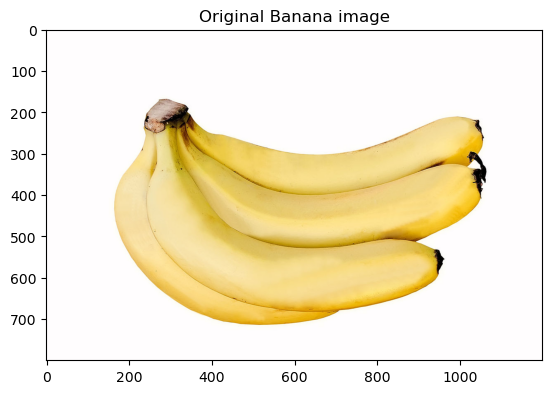

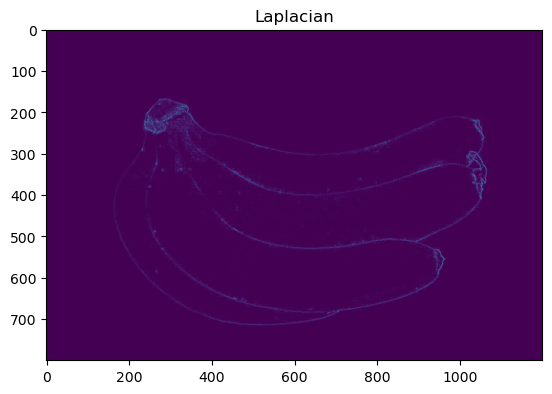

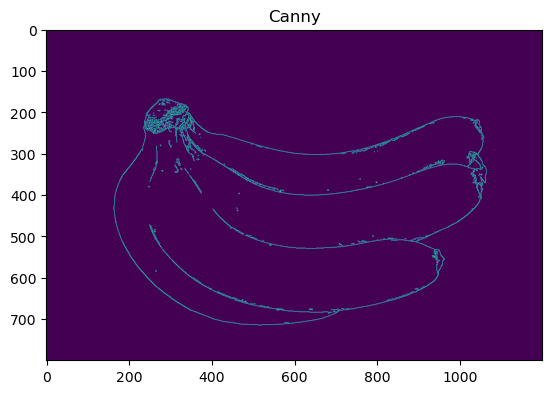

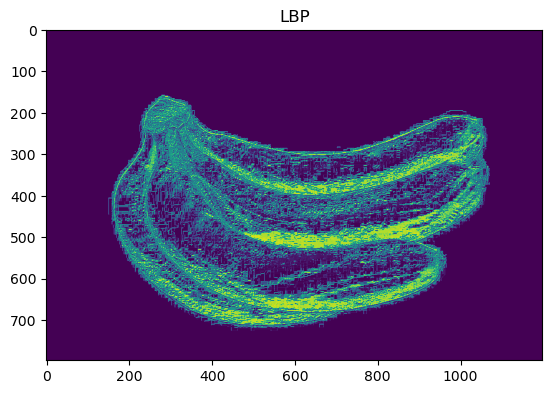

In [9]:
## Edge detected images- this cell is commented 

banana_dir = os.path.join(test_path, 'banana')  # path to the banana subdirectory of the test directory
img_path = os.path.join(banana_dir, 'Image_1.jpg')  # path to the Image_1.jpg file

i1 = Image.open(img_path)
plt.title("Original Banana image")
plt.imshow(i1)
plt.show()

i1_np = np.array(i1.convert("L"))
i3 = np.absolute(cv2.Laplacian(i1_np, cv2.CV_64F))   ## Laplacian
plt.title('Laplacian')
plt.imshow(i3)
plt.show()
 
i4 = cv2.Canny(i1_np, 100, 200)    # Canny
plt.title("Canny")
plt.imshow(i4)
plt.show()

i1 = cv2.imread(img_path)
i2 = LBP(i1)    # Local Binary Pattern
plt.title("LBP")
plt.imshow(i2)
plt.show()


### Creating Train dataframe from the Train images

In [10]:
start_time = time.time()

categories = []
for j in train_folder:
  categories.append(j.split(separator)[-1])

sigma = 3.0
ksize = int(2 * round(3 * sigma) + 1)

labels = []
data = []
ind=0
train_label_dict= {}
for cat in categories:
  path=os.path.join(train_path,cat)
  ind+=1
  train_label_dict.update({ind:cat})
  print(cat,ind)
  # print(path)
  for j in os.listdir(path):
    try:
      img = cv2.imread(os.path.join(path,j))
      img = cv2.resize(img,(64,64))
      
      ## IMPORTANT: The following lines are for image segmentation, whatever the method is used here, 
        ## the same method should be used while creating TEST dataframe and final evaluation of the model
      ########################################
      #img = np.absolute(cv2.Laplacian(img, cv2.CV_64F))    # Laplacian- 2nd order Edge detection
      #img = LBP(img)    # LBP
      img = cv2.Canny(img, 100, 200)     # CANNY
      #img = LoG(img, sigma, ksize)  # LoG
      #img = sobel(img)
      ########################################

      data.append(img.flatten())
      labels.append(ind)
    except:
      pass
      # print(os.path.join(path,j))
    
df = pd.DataFrame(np.array(data))
df['target'] = labels
end_time = time.time()
print(end_time - start_time)

## separating X_train and y_train from the training data df_train
X = df.drop('target',axis=1)
y = df['target']

apple 1
banana 2
beetroot 3
bell pepper 4
cabbage 5
capsicum 6
carrot 7
cauliflower 8
chilli pepper 9
corn 10
cucumber 11
eggplant 12
garlic 13
ginger 14
grapes 15
jalepeno 16
kiwi 17
lemon 18
lettuce 19
mango 20
onion 21
orange 22
paprika 23
pear 24
peas 25
pineapple 26
pomegranate 27
potato 28
raddish 29
soy beans 30
spinach 31
sweetcorn 32
sweetpotato 33
tomato 34
turnip 35
watermelon 36
111.24622511863708


### Creating Test dataframe from the Test images

In [11]:
## TESTING dataset
start_time = time.time()

categories = []
for j in test_folder:
  categories.append(j.split(separator)[-1])

labels = []
data = []
ind=0
test_label_dict= {}
for cat in categories:
  path=os.path.join(test_path,cat)
  ind+=1
  test_label_dict.update({ind:cat})
  print(cat,ind)
  # print(path)
  for j in os.listdir(path):
    try:
      img = cv2.imread(os.path.join(path,j))
      img = cv2.resize(img,(64,64))

      ### IMAGE #####################################
      #img = np.absolute(cv2.Laplacian(img, cv2.CV_64F))    # Laplacian- 2nd order Edge detection
      #img = LBP(img)    # LBP
      img = cv2.Canny(img, 100, 200)     # CANNY
      #img = LoG(img, sigma, ksize)  # LoG
      #img = sobel(img)
      ########################################

      data.append(img.flatten())
      labels.append(ind)
    except:
      print(os.path.join(path,j))
    
df_test = pd.DataFrame(np.array(data))
df_test['target'] = labels
end_time = time.time()
print(end_time - start_time)

# separating X_test and y_test from df_test
X_test = df_test.drop('target',axis=1)
y_test = df_test['target']

apple 1
banana 2
beetroot 3
bell pepper 4
cabbage 5
capsicum 6
carrot 7
cauliflower 8
chilli pepper 9
corn 10
cucumber 11
eggplant 12
garlic 13
ginger 14
grapes 15
jalepeno 16
kiwi 17
lemon 18
lettuce 19
mango 20
onion 21
orange 22
paprika 23
pear 24
peas 25
pineapple 26
pomegranate 27
potato 28
raddish 29
soy beans 30
spinach 31
sweetcorn 32
sweetpotato 33
tomato 34
turnip 35
watermelon 36
19.8437340259552


# Classical ML algorithms

## 1. Support Vector Classifier (SVC)

In [12]:
# Fitting SVC model

svc = SVC(C=0.1, kernel='linear', gamma='auto')

svc.fit(X, y)

with open('svc.pkl', 'wb') as f:
  pickle.dump(svc, f)
f.close()

In [13]:
svc.score(X_test, y_test)

0.9693593314763231

In [16]:
y_pred = svc.predict(X_test)

In [30]:
print(classification_report(y_test, y_pred, target_names=test_label_dict.values()))

               precision    recall  f1-score   support

        apple       1.00      0.80      0.89        10
       banana       1.00      0.89      0.94         9
     beetroot       0.91      1.00      0.95        10
  bell pepper       1.00      1.00      1.00        10
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      1.00      1.00        10
       carrot       1.00      0.90      0.95        10
  cauliflower       0.91      1.00      0.95        10
chilli pepper       1.00      0.90      0.95        10
         corn       0.83      1.00      0.91        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       0.91      1.00      0.95        10
     jalepeno       1.00      1.00      1.00        10
         kiwi       1.00      1.00      1.00        10
        l

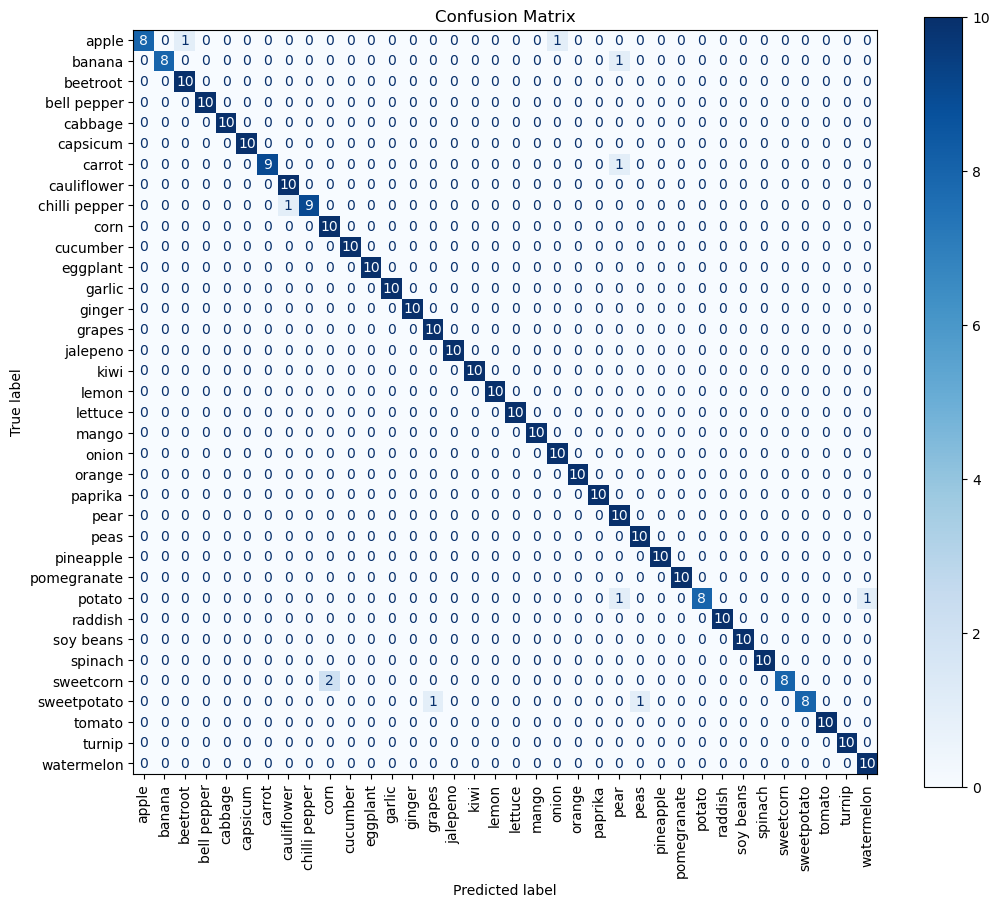

In [29]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_label_dict.values())
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix")
plt.xticks(rotation=90) 
plt.show()


In [14]:
test_label_dict

{1: 'apple',
 2: 'banana',
 3: 'beetroot',
 4: 'bell pepper',
 5: 'cabbage',
 6: 'capsicum',
 7: 'carrot',
 8: 'cauliflower',
 9: 'chilli pepper',
 10: 'corn',
 11: 'cucumber',
 12: 'eggplant',
 13: 'garlic',
 14: 'ginger',
 15: 'grapes',
 16: 'jalepeno',
 17: 'kiwi',
 18: 'lemon',
 19: 'lettuce',
 20: 'mango',
 21: 'onion',
 22: 'orange',
 23: 'paprika',
 24: 'pear',
 25: 'peas',
 26: 'pineapple',
 27: 'pomegranate',
 28: 'potato',
 29: 'raddish',
 30: 'soy beans',
 31: 'spinach',
 32: 'sweetcorn',
 33: 'sweetpotato',
 34: 'tomato',
 35: 'turnip',
 36: 'watermelon'}

In [15]:
## SAVING the LABELS dictionary
with open("labels.json", "w") as f:
    json.dump(test_label_dict, f)
f.close()

## TESTING- Randomly picking a class and an image and checking whether the model has predicted correctly or not using SVC

In [17]:
# TESTING verification
rand_class = random.randint(1, 36)
rand_num = random.randint(1, 10)
test_img_path = test_path +'/'+ str(test_label_dict[rand_class]) + '/Image_'+str(rand_num)+'.jpg'
test_img = cv2.imread(test_img_path)
test_img = cv2.resize(test_img, (64,64))
test_img = cv2.Canny(test_img, 100, 200)    # CANNY edge detection.. if you perform some other edge detection method while training and testing the model, use the same here 
test_img = test_img.flatten().reshape(1,-1)
test_pred_label = svc.predict(test_img)
print(f'The predicted class is: {test_label_dict[test_pred_label[0]]}, and the Actual class is {test_label_dict[rand_class]}')

The predicted class is: paprika, and the Actual class is paprika


## CALORIES CALCULATION of Predicted Fruit/vegetable

### 1. Using Kaggle dataset

In [18]:
## CALORIES CALCULATION

# df_calories = pd.read_csv('/content/Food and Calories - Sheet1.csv')  # this is for google colab

# df_calories = pd.read_csv('/kaggle/input/foodcalories/Food and Calories - Sheet1.csv')  # this is for kaggle

calories_path = os.path.join(current_dir, 'foodcalories')  # path to the data directory
calories_dir = glob(calories_path+separator)

df_calories = pd.read_csv(calories_path+separator+'Food and Calories - Sheet1.csv')   # this is for running in local machine
food = test_label_dict[test_pred_label[0]]
serving = df_calories[df_calories['Food'].str.lower()==test_label_dict[test_pred_label[0]]]['Serving']
cals = df_calories[df_calories['Food'].str.lower()==test_label_dict[test_pred_label[0]]]['Calories']
serving = serving.to_string().split(' ',1)[1].strip()
cals = cals.to_string().split(' ',1)[1].strip()

print(f'Calories in {serving} of {food} is {cals}')

Calories in 1 tbsp (6.8 g) of paprika is 19 cal


In [19]:
## SAVING the df_calories dataframe
df_calories.to_pickle('calories.pkl')

### **2. Using Web-scraping with Beautiful Soup**


In [20]:
url = 'https://www.google.com/search?q=calories+in+' + food
req = requests.get(url).text
scrap = BeautifulSoup(req, 'html.parser')
calories = scrap.find("div", class_="BNeawe iBp4i AP7Wnd").text
# quantity = scrap.find("span", class_="FCUp0c rQMQod").text
print(f'Calories in {food}: {calories}')
# print(quantity)

Calories in paprika: 19 calories


# Classical ML algorithms contd..

## 2. KNN

In [21]:
# we are using KNN as a classification algorithm
from sklearn.neighbors import KNeighborsClassifier

In [22]:
# scaling the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X)
scaled_X_test = scaler.transform(X_test)

In [23]:
knn_model = KNeighborsClassifier(n_neighbors=2)

knn_model.fit(scaled_X_train, y)


KNeighborsClassifier(n_neighbors=2)

In [24]:
knn_model.score(scaled_X_test, y_test)

0.7632311977715878

## 3. Decision Trees

In [51]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X, y)
dt.score(X_test, y_test)

0.958217270194986

## 4. Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X, y)
rfc.score(X_test, y_test)

0.9665738161559888

# EVALUATION: 1. LOADING SVC model from PICKLE file and Labels from JSON file

In [26]:
# LOADING the SVC model from pickle file
f = open("svc.pkl",'rb')
loaded_svc_model = pickle.load(f)
f.close()

In [27]:
with open('labels.json', 'r') as f:
    LABELS = json.load(f)
f.close()

In [33]:
# load images for testing the model
eval_path = os.path.join(current_dir, 'model_eval_images')  # path to the data directory

rand_num = random.randint(1, 20)   # generating a random number between 1 and 20
test_img_path = eval_path + '/Image_'+str(rand_num)+'.jpg'
test_img = cv2.imread(test_img_path)
test_img = cv2.resize(test_img, (64,64))
test_img = cv2.Canny(test_img, 100, 200)    # CANNY edge detection.. if you perform some other edge detection method while training and testing the model, use the same here 
test_img = test_img.flatten().reshape(1,-1)

test_pred_label = loaded_svc_model.predict(test_img)
print(f'The predicted class is: {LABELS[str(test_pred_label[0])]}')

The predicted class is: raddish


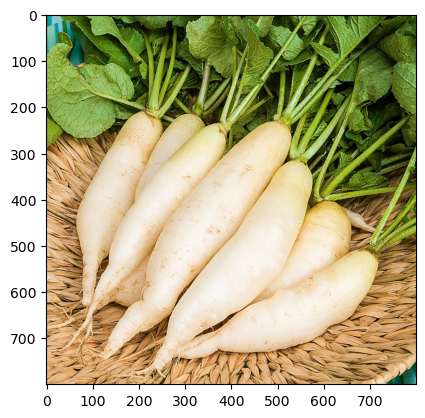

In [34]:
test_img = Image.open(test_img_path)
plt.imshow(test_img);

## EVALUATION: 2. Loading CALORIES from PICKLE file and fetching calories from Predicted fruit/vegetable class

In [35]:
# LOADING the CALORIES from pickle file
f = open("calories.pkl",'rb')
calories = pickle.load(f)
f.close()

In [36]:
food = LABELS[str(test_pred_label[0])]
serving = calories[calories['Food'].str.lower()==LABELS[str(test_pred_label[0])]]['Serving']
cals = calories[calories['Food'].str.lower()==LABELS[str(test_pred_label[0])]]['Calories']
serving = serving.to_string().split(' ',1)[1].strip()
cals = cals.to_string().split(' ',1)[1].strip()

print(f'Calories in {serving} of {food} is {cals}')

Calories in 1 radish (4.5 g) of raddish is 1 cal


## CONCLUSION:

### Out of all the ML algorithms, SVC has given best accuracy of 96.94%

# **Extra: Using CNNs**

## **Using Transfer Learning**

In [53]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16465 sha256=66251759f1d6637038947354b727e623e918701696a355f8f4302c3c48537ca0
  Stored in directory: c:\users\gsikha\appdata\local\pip\cache\wheels\29\16\24\752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
Successfully built efficientnet_pytorch


In [54]:
import cv2

class CannyEdgeDetection(object):
    def __init__(self, threshold1, threshold2):
        self.threshold1 = threshold1
        self.threshold2 = threshold2
    
    def __call__(self, img):
        img = np.array(img)
        img1 = cv2.Canny(img[:,:,0], self.threshold1, self.threshold2)
        img2 = cv2.Canny(img[:,:,1], self.threshold1, self.threshold2)
        img3 = cv2.Canny(img[:,:,2], self.threshold1, self.threshold2)
        img = np.stack([img1, img2, img3], axis=-1)
        img = Image.fromarray(img.astype('uint8'))
        return img

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from efficientnet_pytorch import EfficientNet
import copy

# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the image transformations
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        CannyEdgeDetection(threshold1=100, threshold2=200),  # Add CannyEdgeDetection transform
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        CannyEdgeDetection(threshold1=100, threshold2=200),  # Add CannyEdgeDetection transform
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        CannyEdgeDetection(threshold1=100, threshold2=200),  # Add CannyEdgeDetection transform
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load the datasets
train_dataset = datasets.ImageFolder(train_path, transform=image_transforms['train'])
val_dataset = datasets.ImageFolder(validation_path, transform=image_transforms['val'])
test_dataset = datasets.ImageFolder(test_path, transform=image_transforms['test'])

# Define the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

C:\Users\gsikha\Anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [31]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, device, num_epochs=10):
    model = model.to(device)  # move the model to the GPU
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Training completed')
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def test_model(model, dataloader, device):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    return predictions, targets


In [32]:
# Define the model
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=36)

# Set the optimizer and scheduler
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Train the model
model_trained = train_model(model, criterion, optimizer, scheduler, dataloaders, device, num_epochs=10)

# Test the model
predictions, targets = test_model(model_trained, test_loader, device)
test_acc = accuracy_score(targets, predictions)
print(f"Test accuracy: {test_acc}")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b4
Epoch 1/10
----------


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 2.9000 Acc: 0.2803
val Loss: 1.8827 Acc: 0.5100
Epoch 2/10
----------
train Loss: 1.4164 Acc: 0.6247
val Loss: 0.7159 Acc: 0.7835
Epoch 3/10
----------
train Loss: 0.8704 Acc: 0.7368
val Loss: 0.4127 Acc: 0.8689
Epoch 4/10
----------
train Loss: 0.6279 Acc: 0.8048
val Loss: 0.2907 Acc: 0.9117
Epoch 5/10
----------
train Loss: 0.4494 Acc: 0.8568
val Loss: 0.2687 Acc: 0.9088
Epoch 6/10
----------
train Loss: 0.3685 Acc: 0.8822
val Loss: 0.3097 Acc: 0.9031
Epoch 7/10
----------
train Loss: 0.3018 Acc: 0.9024
val Loss: 0.2035 Acc: 0.9402
Epoch 8/10
----------
train Loss: 0.1889 Acc: 0.9448
val Loss: 0.1649 Acc: 0.9487
Epoch 9/10
----------
train Loss: 0.1860 Acc: 0.9483
val Loss: 0.1555 Acc: 0.9601
Epoch 10/10
----------
train Loss: 0.1552 Acc: 0.9551
val Loss: 0.1540 Acc: 0.9601
Training completed
Best val Acc: 0.960114
Test accuracy: 0.9610027855153204
